In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import 

In [98]:
import lsst.afw.coord
import lsst.afw.geom

In [50]:
import lsst.daf.persistence
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"
DATA_DIR_UNDITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-undithered/"
DATA_DIR_PHOSIM = "/global/cscratch1/sd/descdm/DC1/DC1-phoSim-3a/"

I call the butler to get the data

In [51]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)
butler2 = lsst.daf.persistence.Butler(DATA_DIR_PHOSIM)

In [19]:
skymap = butler.get("deepCoadd_skyMap")

In [102]:
skymap_phosim = butler2.get("deepCoadd_skyMap")

In [103]:
tract = skymap.generateTract(0)

In [104]:
tract_phosim = skymap_phosim.generateTract(0)

In [158]:
print tract_phosim.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(93.0*np.pi/180),lsst.afw.geom.Angle(-29.0*np.pi/180)))
print tract.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(93.0*np.pi/180),lsst.afw.geom.Angle(-29.0*np.pi/180)))

PatchInfo(index=(15, 13))
PatchInfo(index=(17, 13))


In [52]:
print butler.getKeys("deepCoadd_ref")
print butler.getKeys("deepCoadd_calexp")
print butler.getKeys("deepCoadd_meas")

{'patch': <type 'str'>, 'tract': <type 'int'>}
{'filter': <type 'str'>, 'patch': <type 'str'>, 'tract': <type 'int'>}
{'filter': <type 'str'>, 'patch': <type 'str'>, 'tract': <type 'int'>}


In [159]:
exposure_imsim = butler.get("deepCoadd_calexp", filter='r', patch='17,13', tract=0, immediate=True)

In [160]:
exposure_phosim = butler2.get("deepCoadd_calexp", filter='r', patch='15,13', tract=0, immediate=True)

In [161]:
catalog_imsim = butler.get("deepCoadd_ref", patch='17,13', tract=0, immediate=True)

In [162]:
catalog_phosim = butler2.get("deepCoadd_ref", patch='15,13', tract=0, immediate=True)

In [186]:
catalog_phosim.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="merge_footprint_i", doc="Detection footprint overlapped with a detection from filter i"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="merge_footprint_r", doc="Detection footprint overlapped with a detection from filter r"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="merge_footprint_z", doc="Detection footprint overlapped with a detection from filter z"), Key['Flag'](offset=32, bit=3)),
    (Field['Flag'](name="merge_footpri

In [187]:
sel_imsim = np.logical_and(catalog_imsim.get("deblend_nChild")==0,catalog_imsim.get("deblend_masked")==False)
sel_imsim = np.logical_and(sel_imsim,catalog_imsim.get("detect_isPatchInner"))
sel_imsim = np.logical_and(sel_imsim,catalog_imsim.get("base_ClassificationExtendedness_value")==1)

In [188]:
sel_phosim = np.logical_and(catalog_phosim.get("deblend_nChild")==0,catalog_phosim.get("deblend_masked")==False)
sel_phosim = np.logical_and(sel_phosim,catalog_phosim.get("detect_isPatchInner"))
sel_phosim = np.logical_and(sel_phosim,catalog_phosim.get("base_ClassificationExtendedness_value")==1)

In [193]:
print len(catalog_imsim), np.count_nonzero(sel_imsim), 1.0*np.count_nonzero(sel_imsim)/len(sel_imsim)

93552 63855 0.682561570036


In [194]:
print len(catalog_phosim), np.count_nonzero(sel_phosim), 1.0*np.count_nonzero(sel_phosim)/len(sel_phosim)

176768 118188 0.668605177408


In [195]:
calib = exposure_imsim.getCalib()
calib.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMag, psfMagErr = calib.getMagnitude(catalog_imsim.getPsfFlux(), catalog_imsim.getPsfFluxErr())
CModelMag, CModelMagErr = calib.getMagnitude(catalog_imsim.get("modelfit_CModel_flux"), catalog_imsim.get("modelfit_CModel_fluxSigma"))

In [196]:
calibp = exposure_phosim.getCalib()
calibp.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMagp, psfMagErrp = calibp.getMagnitude(catalog_phosim.getPsfFlux(), catalog_phosim.getPsfFluxErr())
CModelMagp, CModelMagErrp = calibp.getMagnitude(catalog_phosim.get("modelfit_CModel_flux"), catalog_phosim.get("modelfit_CModel_fluxSigma"))

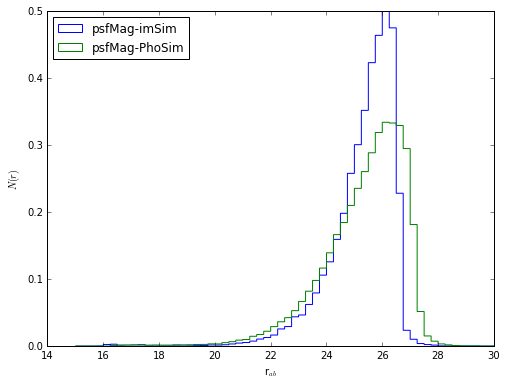

In [198]:
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

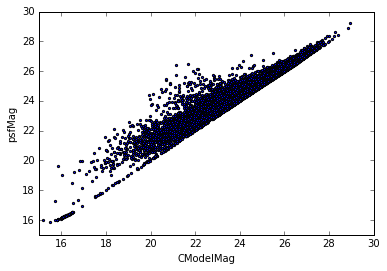

In [199]:
plt.scatter(CModelMag[sel_imsim],psfMag[sel_imsim],marker='.')
plt.xlim(15,30)
plt.ylim(15,30)
plt.xlabel('CModelMag')
plt.ylabel('psfMag')

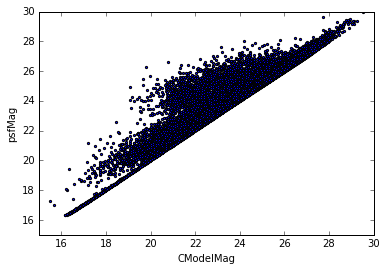

In [200]:
plt.scatter(CModelMagp[sel_phosim],psfMagp[sel_phosim],marker='.')
plt.xlim(15,30)
plt.ylim(15,30)
plt.xlabel('CModelMag')
plt.ylabel('psfMag')

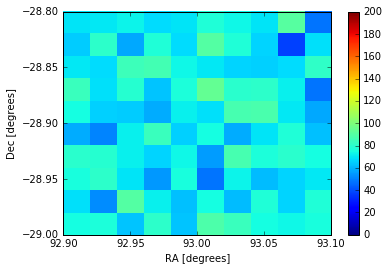

In [206]:
plt.hist2d(catalog_imsim.get("coord_ra")[sel_imsim]*180/np.pi,catalog_imsim.get("coord_dec")[sel_imsim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]],vmin=0,vmax=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

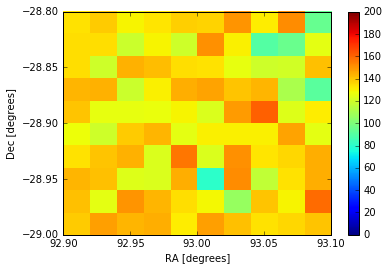

In [205]:
plt.hist2d(catalog_phosim.get("coord_ra")[sel_phosim]*180/np.pi,catalog_phosim.get("coord_dec")[sel_phosim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]],vmin=0,vmax=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

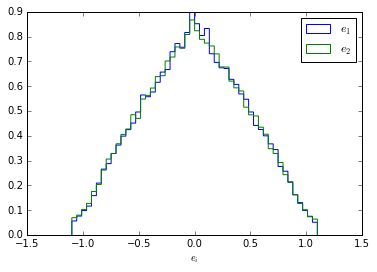

In [208]:
plt.hist(catalog_imsim.get("ext_shapeHSM_HsmShapeRegauss_e1")[sel_imsim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{1}$",normed=True)
plt.hist(catalog_imsim.get("ext_shapeHSM_HsmShapeRegauss_e2")[sel_imsim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{2}$",normed=True)
plt.legend(loc="best")
plt.xlabel(r"$e_{i}$")

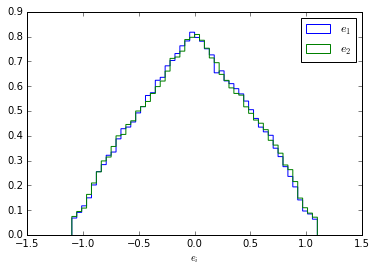

In [210]:
plt.hist(catalog_phosim.get("ext_shapeHSM_HsmShapeRegauss_e1")[sel_phosim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{1}$",normed=True)
plt.hist(catalog_phosim.get("ext_shapeHSM_HsmShapeRegauss_e2")[sel_phosim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{2}$",normed=True)
plt.legend(loc="best")
plt.xlabel(r"$e_{i}$")

In [212]:
reg_imsim = np.logical_and(catalog_imsim.get("coord_ra")*180/np.pi>=92.9,catalog_imsim.get("coord_ra")*180/np.pi<=93.1)
reg_imsim2 = np.logical_and(catalog_imsim.get("coord_dec")*180/np.pi>=-29.0,catalog_imsim.get("coord_dec")*180/np.pi<=-28.8)
sel_imsim_patch = np.logical_and(sel_imsim,reg_imsim)
sel_imsim_patch = np.logical_and(sel_imsim_patch,reg_imsim2)

In [213]:
reg_phosim = np.logical_and(catalog_phosim.get("coord_ra")*180/np.pi>=92.9,catalog_phosim.get("coord_ra")*180/np.pi<=93.1)
reg_phosim2 = np.logical_and(catalog_phosim.get("coord_dec")*180/np.pi>=-29.0,catalog_phosim.get("coord_dec")*180/np.pi<=-28.8)
sel_phosim_patch = np.logical_and(sel_phosim,reg_phosim)
sel_phosim_patch = np.logical_and(sel_phosim_patch,reg_phosim2)

In [214]:
print np.count_nonzero(sel_imsim_patch), np.count_nonzero(sel_phosim_patch)

7170 13319


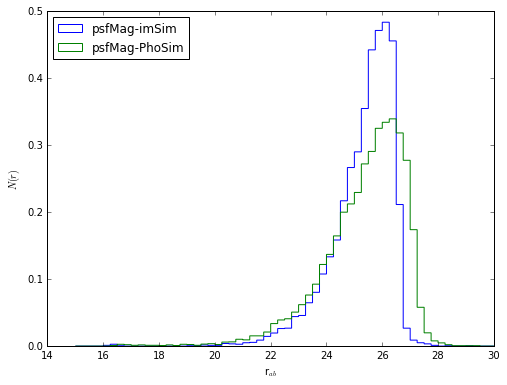

In [215]:
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim_patch],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim_patch],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')